<center><h1>Patel_Datt_HW5</h1></center>
<br>
<br>

Name: Datt Patel
<br>
Github Username: dattpatel99 
<br>
USC ID: 2149812400

## 1. Decision Trees as Interpretable Models

Import packages

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import cross_val_score, KFold
from sklearn import tree
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### (a) Obtain Data

Get the Accute Inamations Data Set

In [98]:
column_names = '''Temperature of patient
Occurrence of nausea
Lumbar pain
Urine pushing (continuous need for urination)
Micturition pains
Burning of urethra, itch, swelling of urethra outlet
Inflammation of urinary bladder
Nephritis of renal pelvis origin'''.split('\n')

In [99]:
diagnosis_path = "../data/diagnosis.data"
with open(diagnosis_path, 'r', encoding="utf8", errors='ignore') as f:
  contents = f.readlines()

diagnosis_data = []
for line in contents:
  clean = line.replace('\x00', '').replace(',','.').replace('\t', ',').replace('\n', '').replace('no', '0').replace('yes', '1').split(',')
  if clean != ['']:
    clean = np.array(clean).astype(float)
    diagnosis_data.append(clean)

diagnosis_data_table = pd.DataFrame(diagnosis_data, columns=column_names)
diagnosis_data_table.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,35.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35.9,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,35.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,36.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,36.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### (b) Build a decision tree

In [100]:
diagnosis_x, diagnosis_y = diagnosis_data_table.iloc[:, :-2], diagnosis_data_table.iloc[:, -2:]

In [101]:
power_set_model = LabelPowerset(classifier= tree.DecisionTreeClassifier(random_state=30))
power_set_model.fit(diagnosis_x, diagnosis_y)

LabelPowerset(classifier=DecisionTreeClassifier(random_state=30),
              require_dense=[True, True])

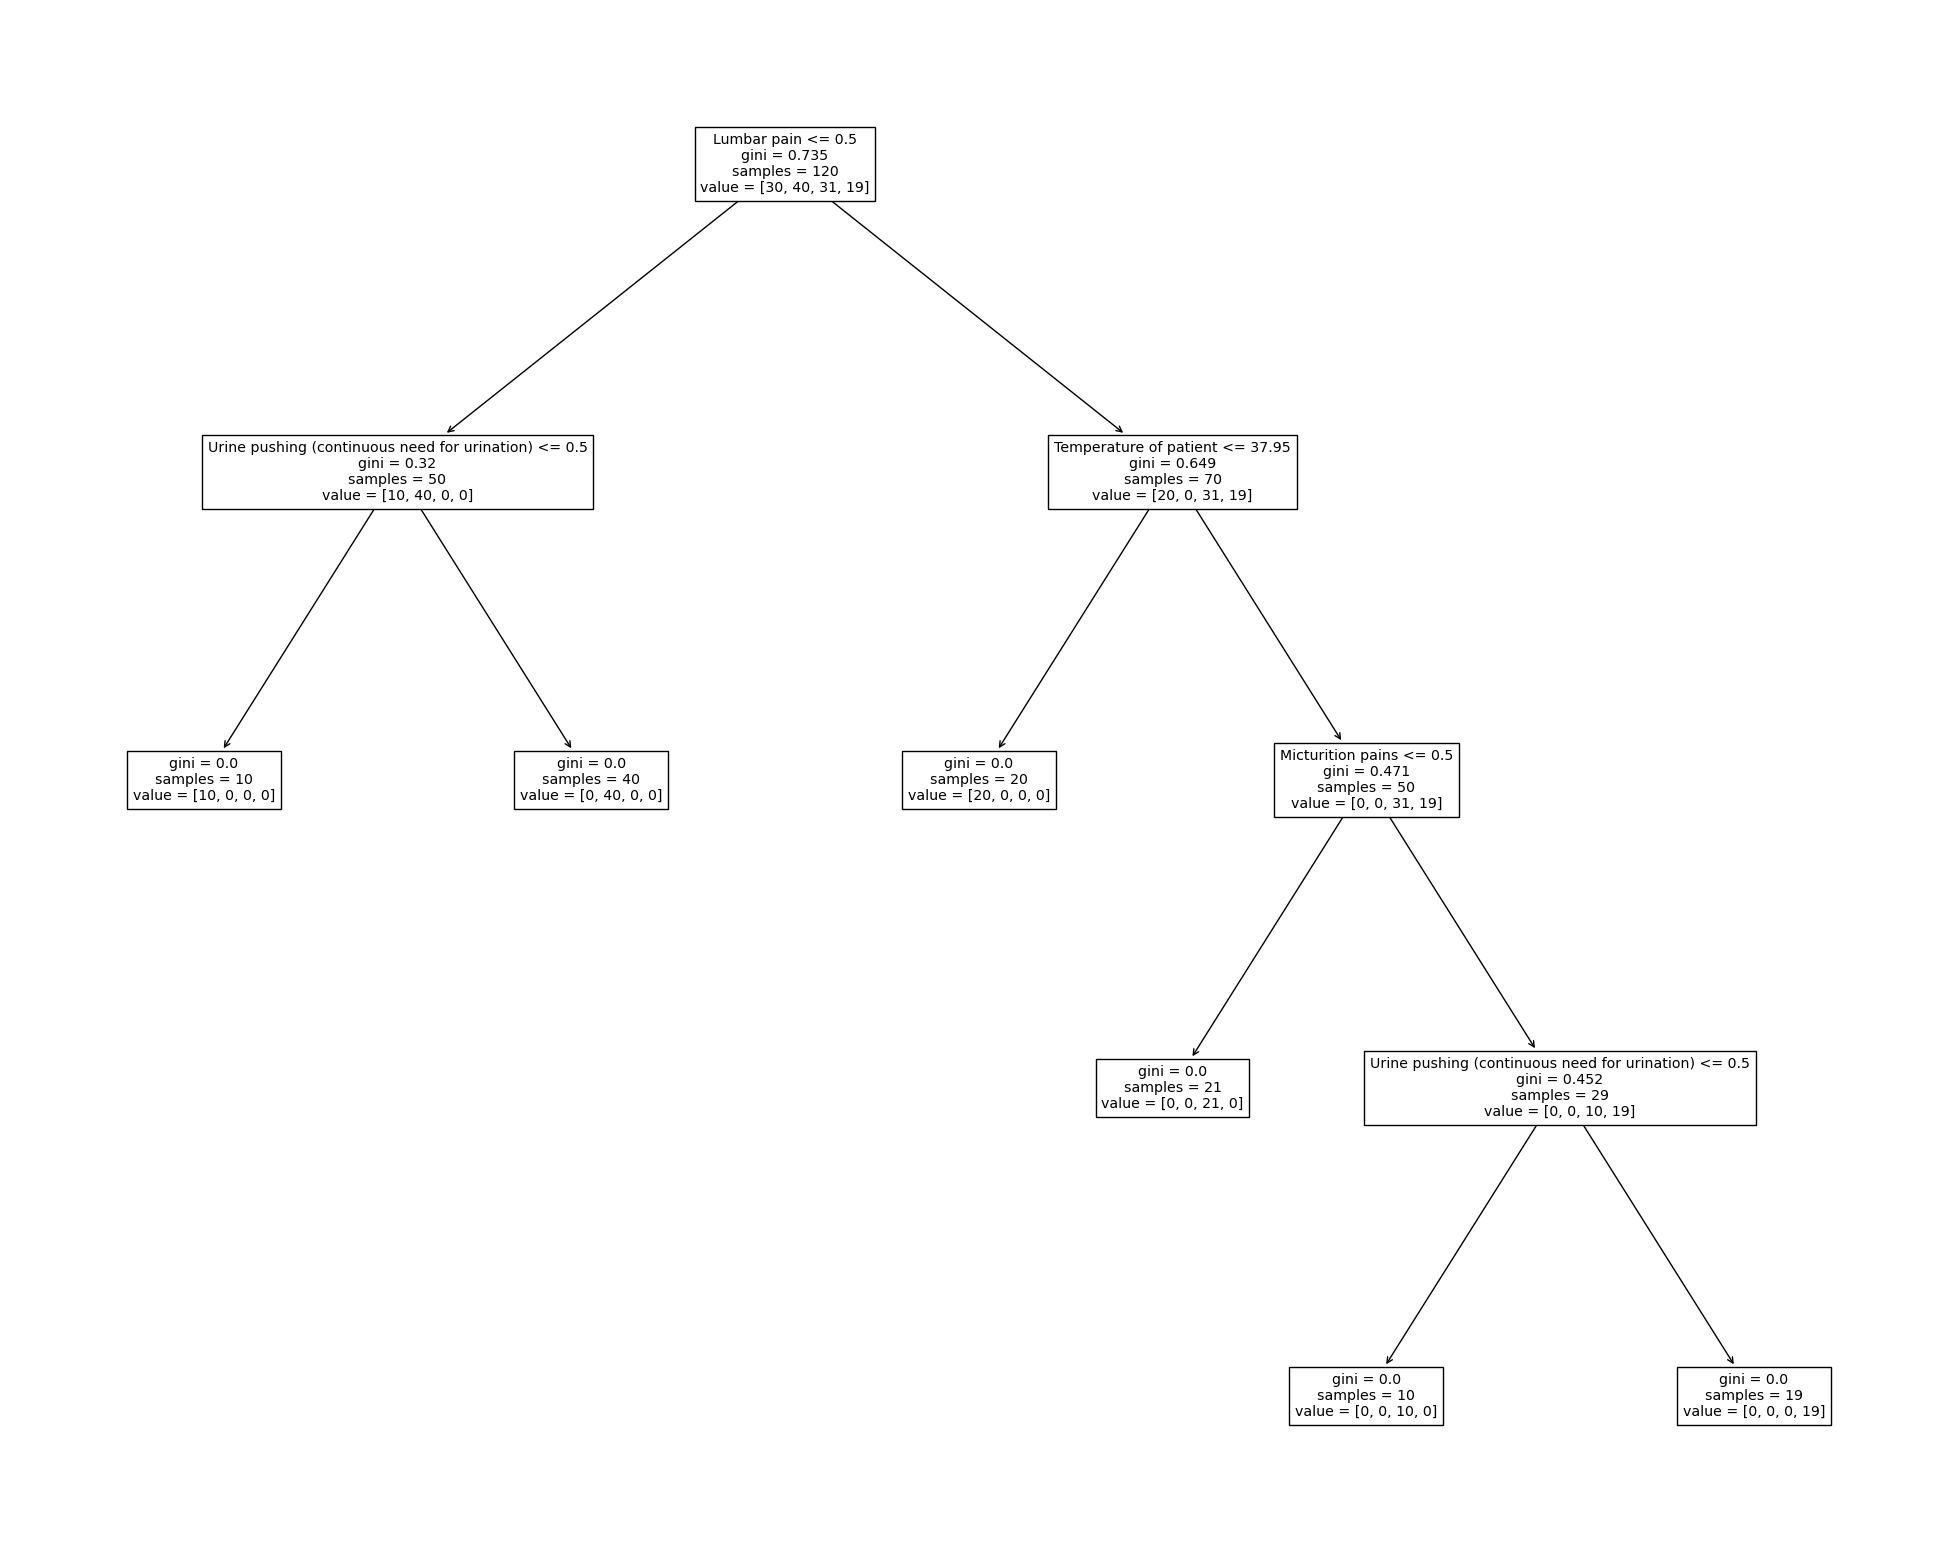

In [102]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(power_set_model.classifier, feature_names=column_names[:-2],label='all')

### (c) Convert the decision rules

In [103]:
def tree_to_pseudo(tree, feature_names):
	"""
	Outputs a decision tree model as if/then pseudocode
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as pseudocode
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"return " + str(value[node]))

	recurse(left, right, threshold, features, 0)

In [104]:
tree_to_pseudo(power_set_model.classifier, column_names[:-2])

 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing (continuous need for urination) <= 0.5 ) {
     return [[10.  0.  0.  0.]]
   } else {
     return [[ 0. 40.  0.  0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } else {
     if ( Micturition pains <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } else {
       if ( Urine pushing (continuous need for urination) <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } else {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


### (d) Cost-Complexity Pruning with CV

In [105]:
# cost complexity pruning on tree
path = power_set_model.classifier.cost_complexity_pruning_path(diagnosis_x, diagnosis_y)
alphas, impurities = path.ccp_alphas, path.impurities

In [106]:
mean, std = [], []
for i in alphas:
   cc_model = LabelPowerset(classifier= tree.DecisionTreeClassifier(ccp_alpha=i, random_state=30))
   # 5 fold cross validation for each alpha value
   scores = cross_val_score(cc_model.classifier, x, y, cv=5)
   mean.append(scores.mean())
   std.append(scores.std())
   
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'Alpha': alphas, 'Mean Score': mean, 'STD Score': std})
eva_df

,Alpha,Mean Score,STD Score
0,0.000000,0.950000,0.100000
1,0.049083,0.741667,0.247768
2,0.079472,0.708333,0.260875
3,0.111111,0.566667,0.140929
4,0.204236,0.200000,0.209828


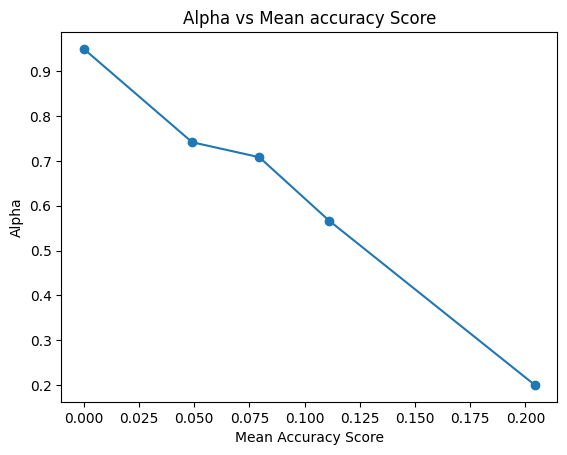

In [107]:
plt.plot(eva_df['Alpha'], eva_df['Mean Score'], marker='o')
plt.title('Alpha vs Mean accuracy Score')
plt.xlabel('Mean Accuracy Score')
plt.ylabel('Alpha')
plt.show()

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [108]:
comm_column_names = '''state
county
community
communityname
fold
population
householdsize
racepctblack
racePctWhite
racePctAsian
racePctHisp
agePct12t21
agePct12t29
agePct16t24
agePct65up
numbUrban
pctUrban
medIncome
pctWWage
pctWFarmSelf
pctWInvInc
pctWSocSec
pctWPubAsst
pctWRetire
medFamInc
perCapInc
whitePerCap
blackPerCap
indianPerCap
AsianPerCap
OtherPerCap
HispPerCap
NumUnderPov
PctPopUnderPov
PctLess9thGrade
PctNotHSGrad
PctBSorMore
PctUnemployed
PctEmploy
PctEmplManu
PctEmplProfServ
PctOccupManu
PctOccupMgmtProf
MalePctDivorce
MalePctNevMarr
FemalePctDiv
TotalPctDiv
PersPerFam
PctFam2Par
PctKids2Par
PctYoungKids2Par
PctTeen2Par
PctWorkMomYoungKids
PctWorkMom
NumIlleg
PctIlleg
NumImmig
PctImmigRecent
PctImmigRec5
PctImmigRec8
PctImmigRec10
PctRecentImmig
PctRecImmig5
PctRecImmig8
PctRecImmig10
PctSpeakEnglOnly
PctNotSpeakEnglWell
PctLargHouseFam
PctLargHouseOccup
PersPerOccupHous
PersPerOwnOccHous
PersPerRentOccHous
PctPersOwnOccup
PctPersDenseHous
PctHousLess3BR
MedNumBR
HousVacant
PctHousOccup
PctHousOwnOcc
PctVacantBoarded
PctVacMore6Mos
MedYrHousBuilt
PctHousNoPhone
PctWOFullPlumb
OwnOccLowQuart
OwnOccMedVal
OwnOccHiQuart
RentLowQ
RentMedian
RentHighQ
MedRent
MedRentPctHousInc
MedOwnCostPctInc
MedOwnCostPctIncNoMtg
NumInShelters
NumStreet
PctForeignBorn
PctBornSameState
PctSameHouse85
PctSameCity85
PctSameState85
LemasSwornFT
LemasSwFTPerPop
LemasSwFTFieldOps
LemasSwFTFieldPerPop
LemasTotalReq
LemasTotReqPerPop
PolicReqPerOffic
PolicPerPop
RacialMatchCommPol
PctPolicWhite
PctPolicBlack
PctPolicHisp
PctPolicAsian
PctPolicMinor
OfficAssgnDrugUnits
NumKindsDrugsSeiz
PolicAveOTWorked
LandArea
PopDens
PctUsePubTrans
PolicCars
PolicOperBudg
LemasPctPolicOnPatr
LemasGangUnitDeploy
LemasPctOfficDrugUn
PolicBudgPerPop
ViolentCrimesPerPop'''.split('\n')

In [109]:
comm_path = "../data/communities.csv"
comm_data_table = pd.read_csv(comm_path, names=comm_column_names)
comm_data_table.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [110]:
comm_data_table = comm_data_table.replace('?', None)

In [111]:
train, test = comm_data_table.iloc[:1495,:], comm_data_table.iloc[1495:,:]

### (b) Missing values

In [112]:
predictive_columns = comm_column_names[5:]

In [113]:
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputated_data = imputer.fit_transform(comm_data_table[predictive_columns])

In [114]:
comm_data_table[comm_data_table.columns[5:]] = imputated_data
comm_data_table.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,None,None,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,53,None,None,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,24,None,None,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


In [115]:
train, test = comm_data_table.iloc[:1495, 5:], comm_data_table.iloc[1495:, 5:]

### (c) Plot a correlation matrix

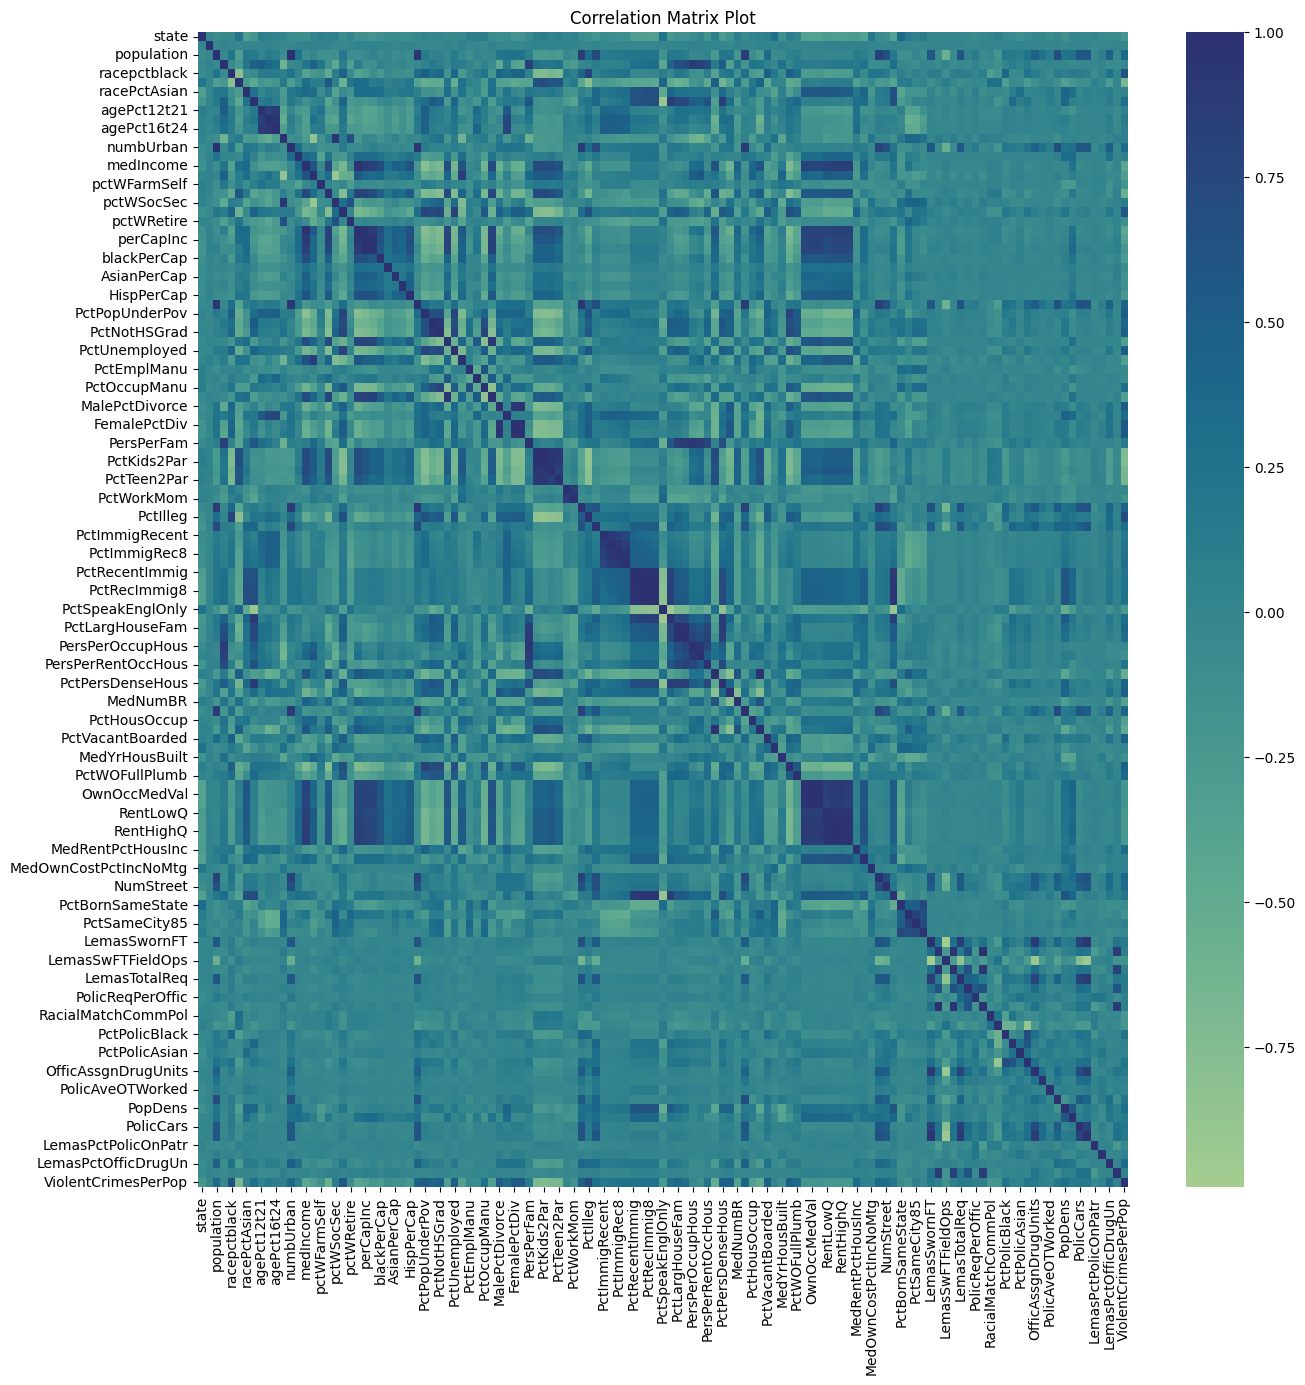

In [116]:
fig, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(comm_data_table.corr(), cmap='crest',ax=axes)
plt.title("Correlation Matrix Plot")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [117]:
coefficient_variation = np.array(comm_data_table.iloc[:, 5:].describe().T['std'])/np.array(comm_data_table.iloc[:, 5:].describe().T['mean'])
cv_table = pd.DataFrame(zip(predictive_columns, coefficient_variation))
cv_table

,0,1
0,population,2.203503
1,householdsize,0.353298
2,racepctblack,1.410920
3,racePctWhite,0.323782
4,racePctAsian,1.359162
...,...,...
118,LemasPctPolicOnPatr,0.122331
119,LemasGangUnitDeploy,0.368040
120,LemasPctOfficDrugUn,2.555266
121,PolicBudgPerPop,0.337281


In [118]:
cv_table = cv_table.sort_values(by=1, ascending=False)
# Pick Root(128) best features
best_features = cv_table.iloc[:int(np.sqrt(128)), 0]
best_features

90               NumStreet
89           NumInShelters
49                NumIlleg
51                NumImmig
120    LemasPctOfficDrugUn
27             NumUnderPov
0               population
10               numbUrban
71              HousVacant
113               LandArea
5              racePctHisp
Name: 0, dtype: object

### (e) Scatter plots and box plots for highest CV features

### Scatter Plot

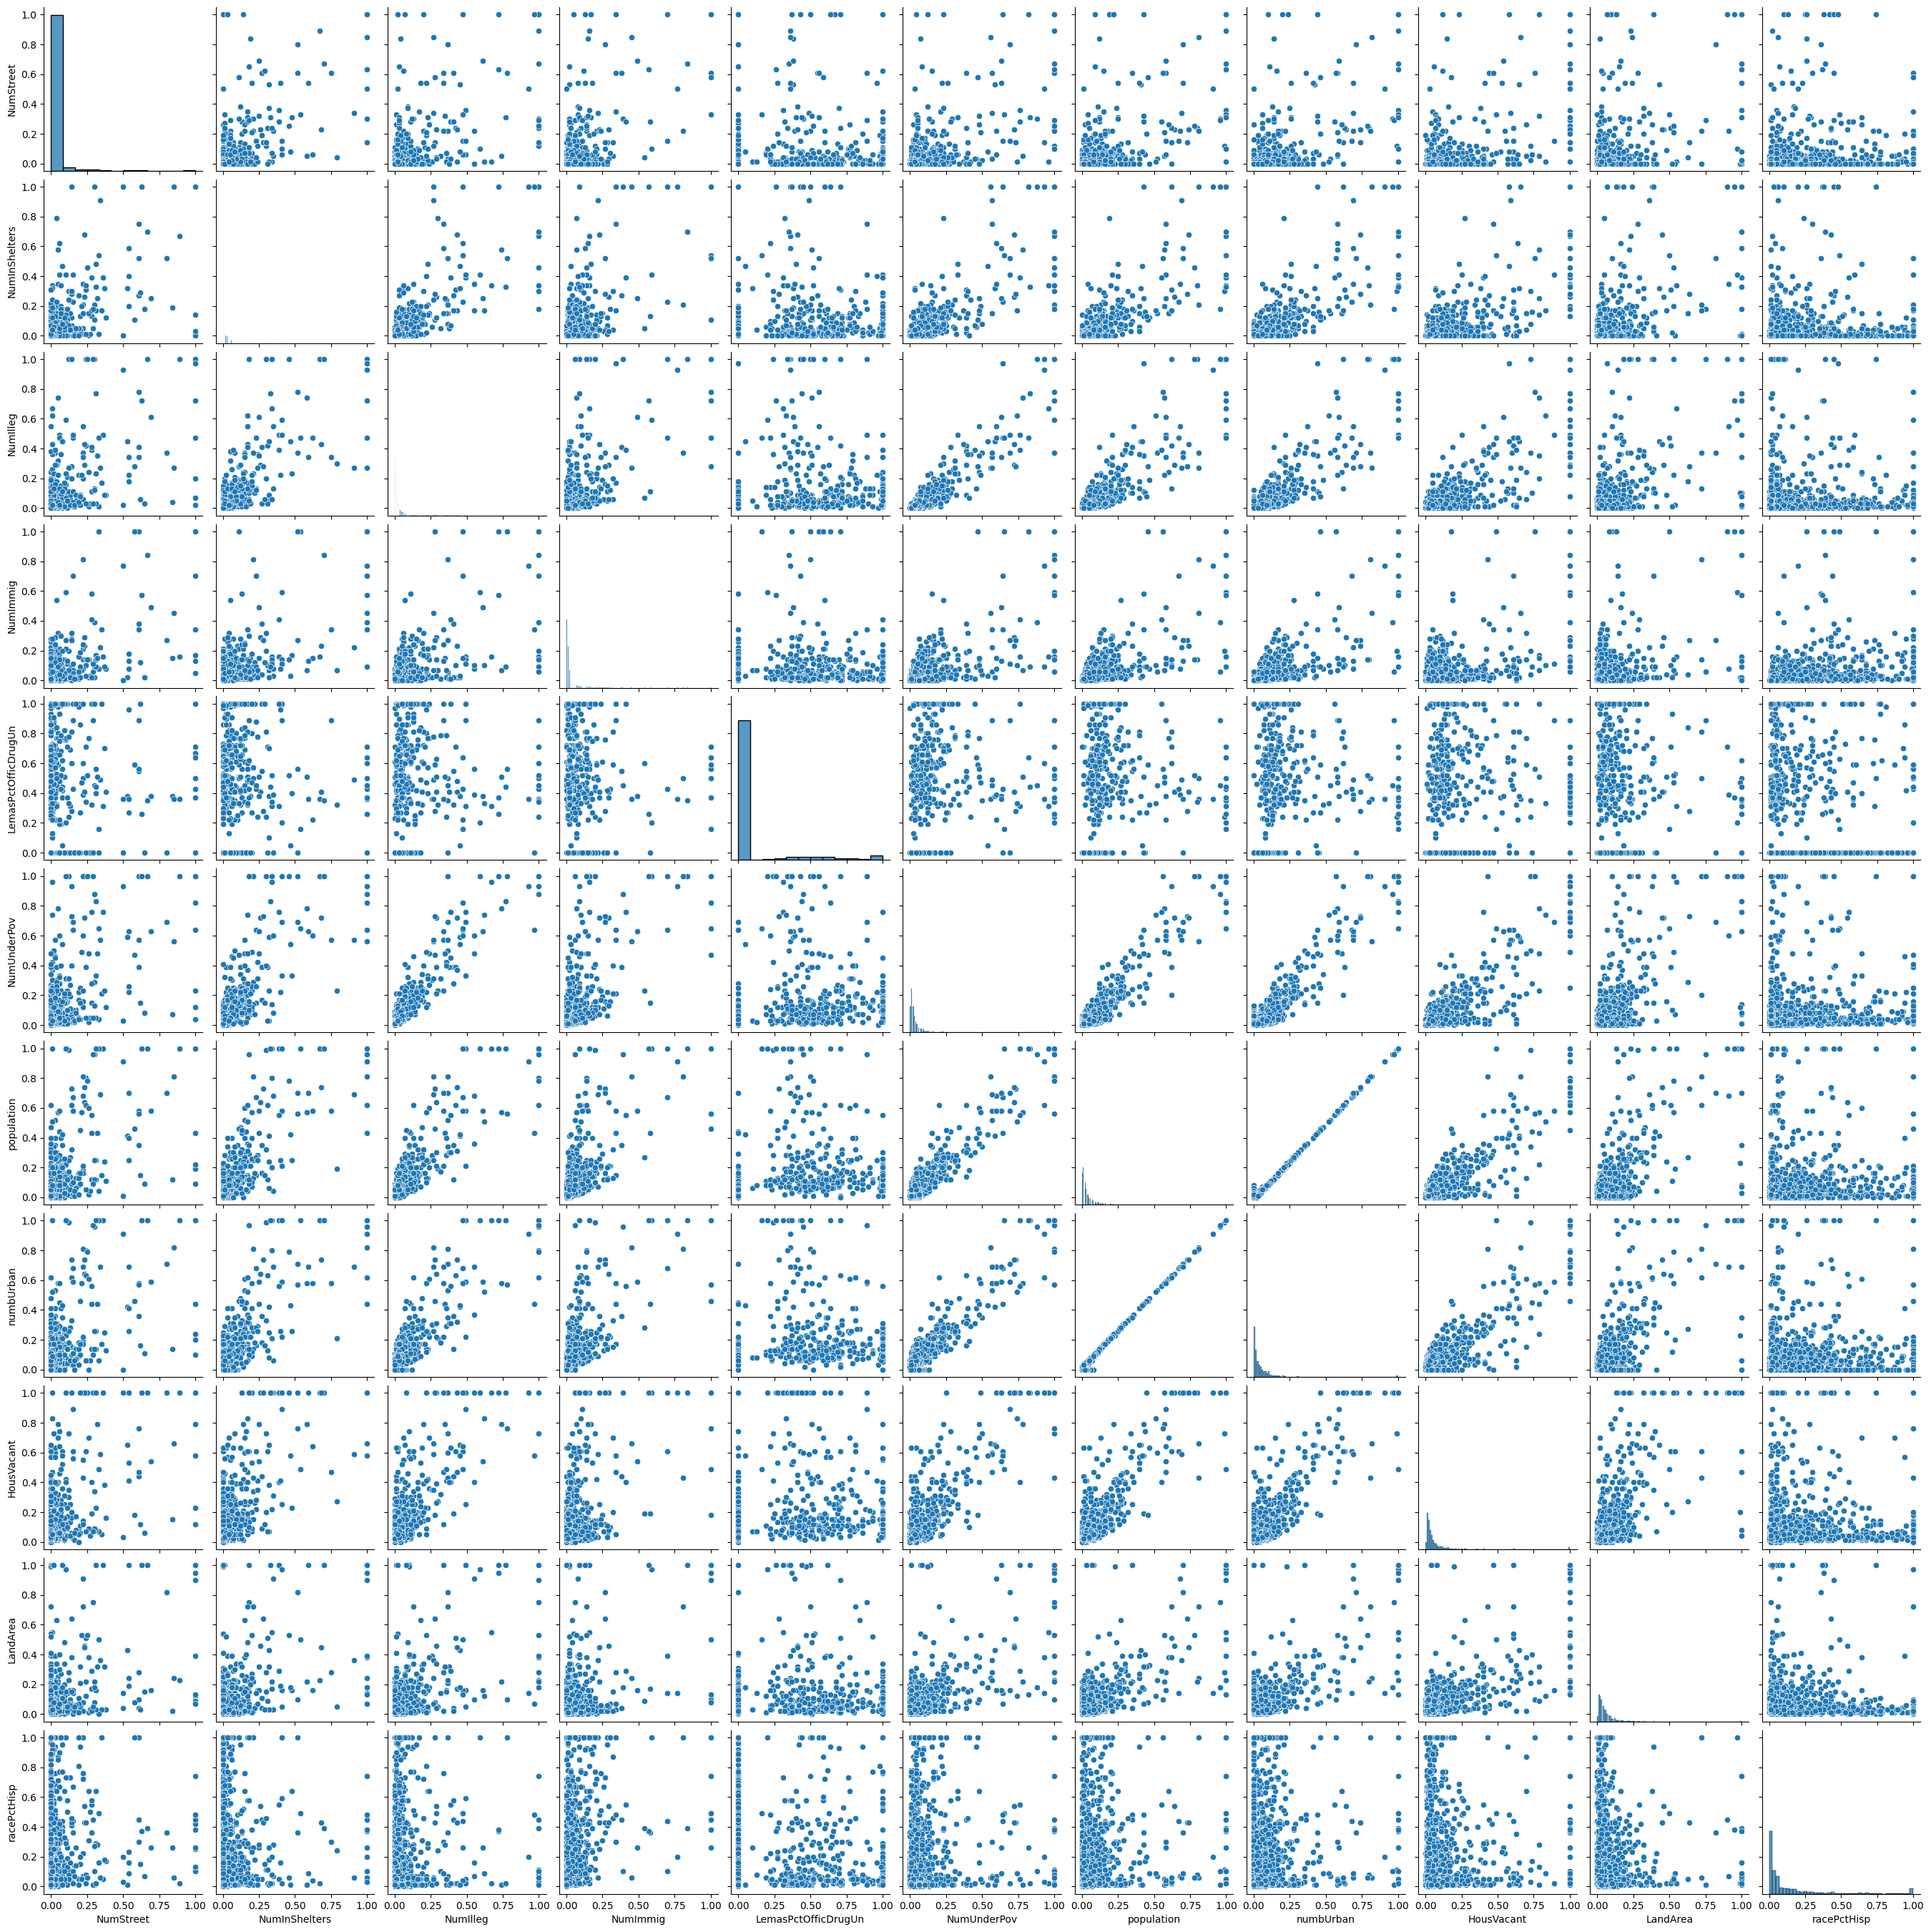

In [119]:
sns.pairplot(comm_data_table[best_features])

### Boxplot

<AxesSubplot: >

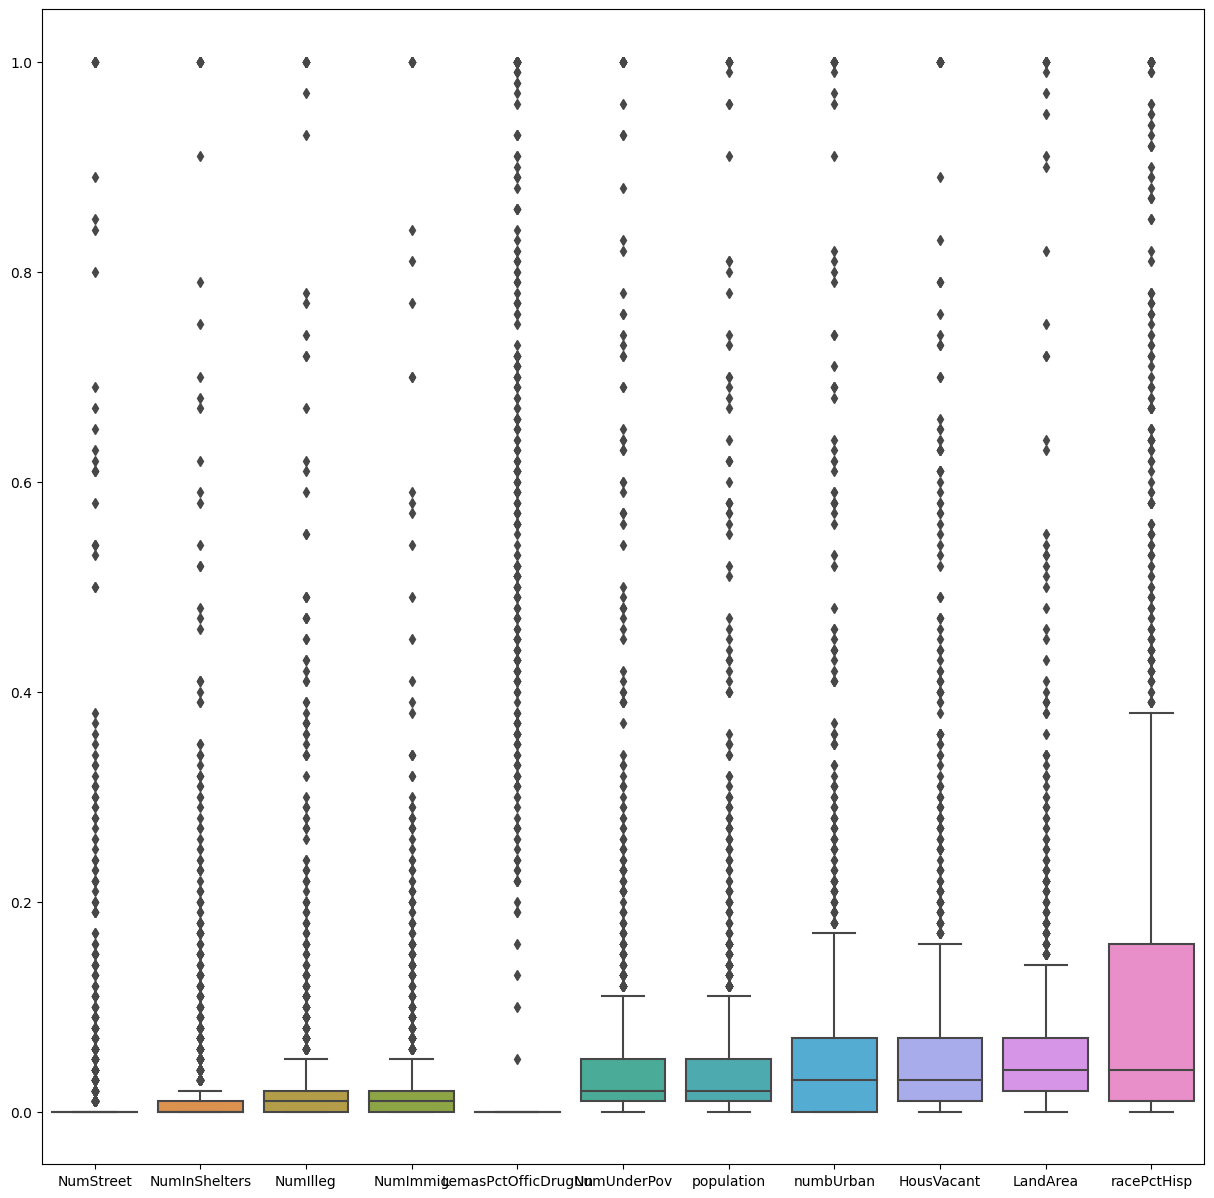

In [120]:
fig, axes = plt.subplots(figsize=(15, 15))
sns.boxplot(data=comm_data_table[best_features], ax=axes)

I belive we can't use the scatter plots to identify the significance of each feature.

### (f) Fit a linear model

In [121]:
mse_table = {}

In [122]:
train_x, train_y, test_x, test_y = train.iloc[:, :-1], train.iloc[:, -1], test.iloc[:, :-1], test.iloc[:, -1]

In [123]:
linear_model = LinearRegression()
linear_model.fit(train_x, train_y)
linear_yhat = linear_model.predict(test_x)
linear_mse = mean_squared_error(test_y, linear_yhat)
print('The linear model has an MSE of {}'.format(np.round(linear_mse, 5)))
mse_table['Linear'] = np.round(linear_mse, 5)

The linear model has an MSE of 0.78973


### (g) Fit a ridge regression model

In [124]:
lambda_range = np.arange(0.001,3.0,0.001)
splitter = KFold(n_splits=5, shuffle=True, random_state=30)

ridge_model = RidgeCV(alphas=lambda_range, cv=splitter).fit(train_x, train_y)
print('Best Lambda value = {}'.format(ridge_model.alpha_))

ridge_yhat = ridge_model.predict(test_x)
ridge_mse = mean_squared_error(test_y, ridge_yhat)

print('MSE for Ridge Regression is {}'.format(np.round(ridge_mse, 5)))
mse_table['Ridge'] = np.round(ridge_mse, 5)

Best Lambda value = 2.999
MSE for Ridge Regression is 0.01757


### (h) Fit a LASSO model

#### Creating Stadnarized Data

In [125]:
standarized_train_x = StandardScaler().fit_transform(train_x)
standarized_test_x = StandardScaler().fit_transform(test_x)

#### Non-Standarized

In [126]:
lasso_model = LassoCV(alphas=lambda_range, cv=splitter, max_iter=500).fit(train_x, train_y)
print('Best Lambda value for the Lasso model(non-standarized data): {}'. format(lasso_model.alpha_))
lasso_yhat = lasso_model.predict(test_x)
lasso_mse = mean_squared_error(test_y, lasso_yhat)
print('MSE for Lasso model(non-standarized data) is {}'.format(np.round(lasso_mse,5)))
mse_table['Lasso Non-Standarized'] = np.round(lasso_mse, 5)

Best Lambda value for the Lasso model(non-standarized data): 0.001
MSE for Lasso model(non-standarized data) is 0.01755


In [127]:
pd.DataFrame(data=lasso_model.coef_[lasso_model.coef_ != 0], columns=['Coefficients'], index= train_x.columns[lasso_model.coef_ != 0])

,Coefficients
racepctblack,0.211027
racePctWhite,-0.011076
agePct12t29,-0.005967
pctUrban,0.038246
pctWPubAsst,0.029043
AsianPerCap,0.010083
MalePctDivorce,0.145153
PctKids2Par,-0.215357
PctYoungKids2Par,-0.006970
PctWorkMom,-0.049358


#### Standarized

In [128]:
lasso_model_stand = LassoCV(alphas=lambda_range, cv=splitter, max_iter=500).fit(standarized_train_x, train_y)
print('Best Lambda value for the Lasso model(standarized data): {}'. format(lasso_model_stand.alpha_))
lasso_yhat_stand = lasso_model_stand.predict(standarized_test_x)
lasso_mse_stand = mean_squared_error(test_y, lasso_yhat_stand)
print('MSE for Lasso model(standarized data) is {}'.format(np.round(lasso_mse_stand,5)))
mse_table['Lasso Standarized'] = np.round(lasso_mse_stand, 5)

Best Lambda value for the Lasso model(standarized data): 0.003
MSE for Lasso model(standarized data) is 0.01775


In [129]:
pd.DataFrame(data=lasso_model_stand.coef_[lasso_model_stand.coef_ != 0], columns=['Coefficients'], index=train_x.columns[lasso_model_stand.coef_ != 0])

,Coefficients
racepctblack,0.057682
agePct12t29,-0.011316
pctUrban,0.014800
pctWInvInc,-0.005950
pctWPubAsst,0.001744
pctWRetire,-0.007495
indianPerCap,-0.001760
AsianPerCap,0.003127
OtherPerCap,0.001258
MalePctDivorce,0.019855


Based on the results above we can see that the non-standarized values allow for better results as it has lower number of features ledt at the end and a lower MSE score.

### (i) Fit a PCR model

In [130]:
pca_mse = []
num_components = [i for i in range(1, len(train_x.columns)+1)]
# Calculate MSE using cross-validation, adding one component at a time
for i in num_components:
    pca_x_reduced = PCA(n_components=i).fit_transform(train_x)
    score = -1*cross_val_score(LinearRegression(), pca_x_reduced, train_y, cv=splitter, scoring='neg_mean_squared_error').mean()
    pca_mse.append(score)

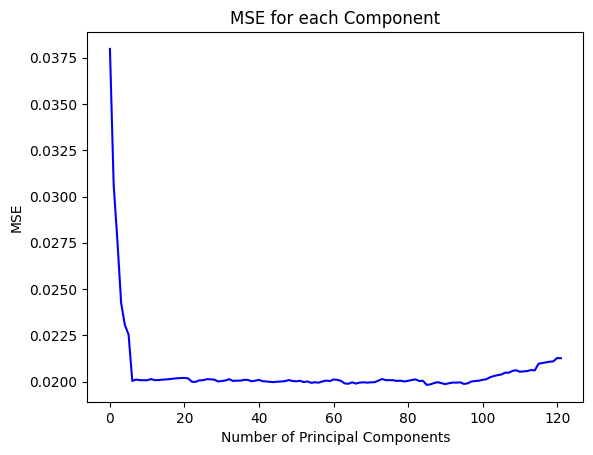

Min MSE = 0.01982, when Number of Components = 86


In [131]:
plt.plot(pca_mse, color='Blue')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE for each Component')
plt.show()

print('Min MSE = {}, when Number of Components = {}'.format(np.round(np.min(pca_mse),5), num_components[np.argmin(pca_mse)]))

In [132]:
pca_train_x = PCA(n_components= 86).fit_transform(train_x)
pca_test_x = PCA(n_components= 86).fit_transform(test_x)
pca_model = LinearRegression().fit(pca_train_x, train_y)
pca_yhat = pca_model.predict(pca_test_x)
pca_mse_score = mean_squared_error(test_y, pca_yhat)
print('PCR MSE = {}'.format(np.round(pca_mse_score,5)))
mse_table['PCR'] = np.round(pca_mse_score, 5)

PCR MSE = 0.0287


### (j) Fit a boosting tree

In [133]:
xgb_scores = []
# Tried running with original Lambda from above but score has very little difference therefore shifted to a faster method of computation covering wider range
lambda_range = [10**i for i in range(-5,5)]
for i in lambda_range:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',reg_alpha=i)
    score = -1*cross_val_score(xgb_model, train_x, train_y, cv=splitter, scoring='neg_mean_squared_error').mean()
    xgb_scores.append(score)

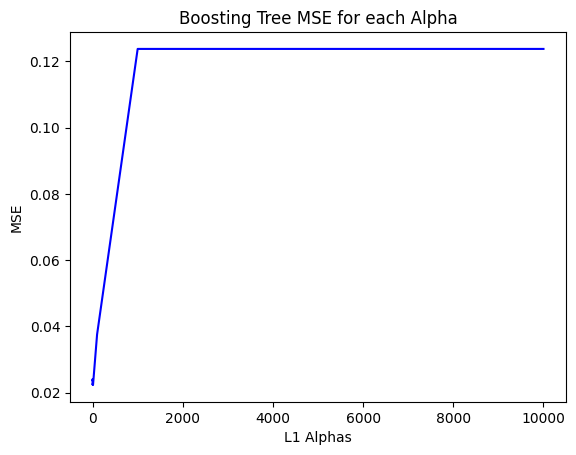

Min MSE = 0.02236, when Lambda = 10


In [134]:
plt.plot(lambda_range, xgb_scores, color='Blue')
plt.xlabel('L1 Alphas')
plt.ylabel('MSE')
plt.title('Boosting Tree MSE for each Alpha')
plt.show()

print('Min MSE = {}, when Lambda = {}'.format(np.round(np.min(xgb_scores),5), lambda_range[np.argmin(xgb_scores)]))

In [135]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',reg_alpha= 10).fit(train_x, train_y)
xgb_predict = xgb_model.predict(test_x)
xgb_mse = np.round(mean_squared_error(test_y, xgb_predict), 5)
print('MSE for xgb: {}'.format(xgb_mse))
mse_table['Boosting'] = np.round(xgb_mse, 5)

MSE for xgb: 0.01841


In [136]:
pd.DataFrame(mse_table, index=['MSE']).T

,MSE
Linear,0.78973
Ridge,0.01757
Lasso Non-Standarized,0.01755
Lasso Standarized,0.01775
PCR,0.02870
Boosting,0.01841


# References:

https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4

https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html.

https://www.statology.org/principal-components-regression-in-python/

https://xgboost.readthedocs.io/en/stable/install.html
